In [1]:
# Cell 1 – Imports & load
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
FEATS = pd.read_parquet(Path("../data/parquet/features.parquet"))
print(FEATS.shape, "rows × columns")

(1004534, 14) rows × columns


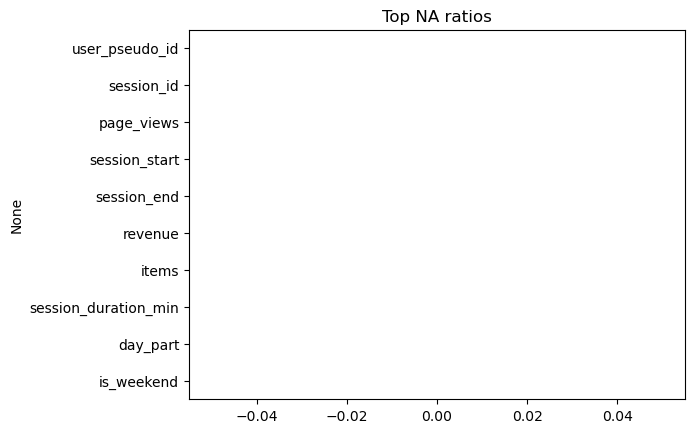

In [2]:
# Cell 2 – Missing-value audit
nulls = FEATS.isna().mean().sort_values(ascending=False).head(10)
sns.barplot(x=nulls.values, y=nulls.index); plt.title("Top NA ratios");


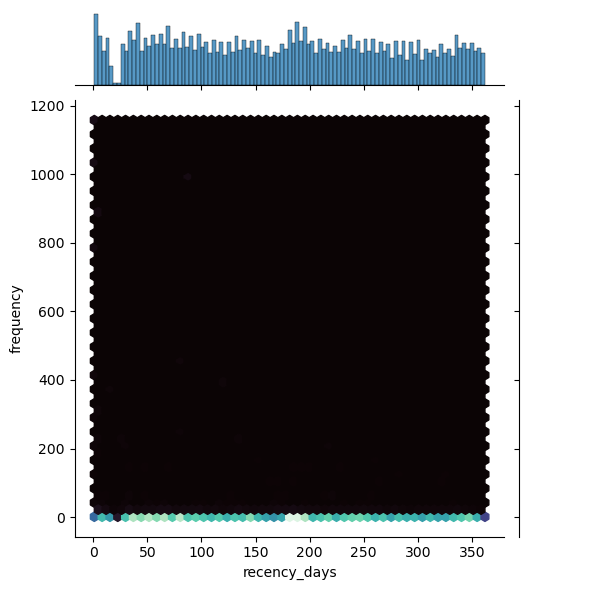

In [3]:
# Cell 3 – Recency-Frequency joint plot
sns.jointplot(data=FEATS, x="recency_days", y="frequency",
              kind="hex", height=6, cmap="mako")


In [7]:
# Cell 4 – RFM scaling for clustering
"""from sklearn.preprocessing import StandardScaler
RFM_scaled = StandardScaler().fit_transform(
    FEATS[["recency_days","frequency","monetary_value"]])"""

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
RFM_scaled = scaler.fit_transform(FEATS[["recency_days","frequency","monetary_value"]])


recency_days cut-off  : max 365  
scaler               : StandardScaler (mean 0, var 1)
k-range for K-means  : 3-8 (select by silhouette)


Prepare the matrix

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import pandas as pd, numpy as np, joblib, matplotlib.pyplot as plt

RFM = FEATS[["recency_days", "frequency", "monetary_value"]]
X    = StandardScaler().fit_transform(RFM)


Pick k (elbow + silhouette)

In [10]:
inertias, sils = [], []
for k in range(3, 9):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    lbl = km.fit_predict(X)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, lbl))

plt.plot(range(3,9), inertias, marker="o"); plt.title("Elbow");
plt.figure(); plt.plot(range(3,9), sils, marker="o"); plt.title("Silhouette");


KeyboardInterrupt: 

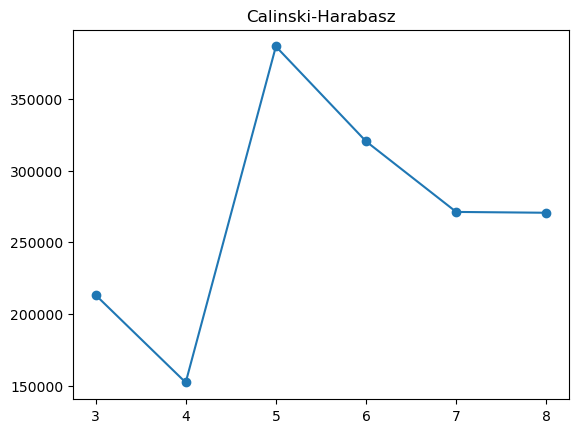

Best k = 5


In [11]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import calinski_harabasz_score
import numpy as np, matplotlib.pyplot as plt

X = RFM_scaled.astype("float32")          # keeps RAM lower
chs = []
for k in range(3, 9):
    km = MiniBatchKMeans(n_clusters=k, batch_size=10_000,
                         random_state=42, n_init=10)
    lbl = km.fit_predict(X)
    chs.append(calinski_harabasz_score(X, lbl))

plt.plot(range(3,9), chs, marker="o")
plt.title("Calinski-Harabasz"); plt.show()
BEST_K = int(np.argmax(chs)) + 3
print("Best k =", BEST_K)


Choose the k with the highest silhouette (> 0.25) that’s still near the elbow.

Final model & labels

In [12]:
from sklearn.cluster import MiniBatchKMeans
import joblib, pathlib

# 1. Fit the final model on ALL rows
final_km = MiniBatchKMeans(
    n_clusters=5,
    batch_size=10_000,
    n_init=20,
    random_state=42
)
FEATS["segment"] = final_km.fit_predict(X)

In [13]:
# 2. Save the segment map (for later merge in Phase 3/4)
FEATS[["user_pseudo_id", "segment"]].to_parquet(
    "../data/parquet/segment_map.parquet", index=False
)

In [14]:
# 3. Persist the model
joblib.dump(final_km, pathlib.Path("src") / "kmeans_rfm.pkl")

print("✅ 5-cluster MiniBatch K-means fitted and saved")

FileNotFoundError: [Errno 2] No such file or directory: 'src\\kmeans_rfm.pkl'

Profile clusters (optional)

In [15]:
import pathlib, joblib

MODEL_PATH = pathlib.Path("..") / "src" / "kmeans_rfm.pkl"   # ../src/…
joblib.dump(final_km, MODEL_PATH)
print("✅ 5-cluster MiniBatch K-means fitted and saved")
print("✅ model saved to", MODEL_PATH.resolve())


✅ 5-cluster MiniBatch K-means fitted and saved
✅ model saved to C:\Users\koppu\AIgnition_Hackathon\src\kmeans_rfm.pkl


In [16]:
import os; print(os.path.getsize(MODEL_PATH)//1024, "KB")


3924 KB


In [17]:
FEATS.groupby("segment")[["recency_days","frequency","monetary_value"]].median()


,recency_days,frequency,monetary_value
segment,,,
0,316.0,1.0,0.0
1,55.0,1.0,0.0
2,2.0,997.0,0.0
3,225.0,1.0,0.0
4,143.0,1.0,0.0
